In [1]:
cd /home/jibancat/Documents/PYTHON/matter_emu_dgmgp

/home/jibancat/Documents/PYTHON/matter_emu_dgmgp


In [2]:
from typing import List

import os

In [3]:
import numpy as np
import h5py
import json
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# change some plotting defaults
# plt.rc('xtick',labelsize=26)
# plt.rc('ytick',labelsize=26)
# plt.rcParams['xtick.major.size'] = 8
# plt.rcParams['xtick.major.width'] = 1.5
# plt.rcParams['xtick.minor.size'] = 5
# plt.rcParams['xtick.minor.width'] = 1.25
# plt.rcParams['ytick.major.size'] = 8
# plt.rcParams['ytick.major.width'] = 1.5
# plt.rcParams['ytick.minor.size'] = 5
# plt.rcParams['ytick.minor.width'] = 1.25
# plt.rcParams['axes.linewidth'] = 2
matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

matplotlib.rcParams['figure.dpi']= 150

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

In /home/jibancat/.pyenv/versions/miniconda3-4.3.31/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jibancat/.pyenv/versions/miniconda3-4.3.31/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/jibancat/.pyenv/versions/miniconda3-4.3.31/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/jibancat/.pyenv/versions/miniconda3-4.3.31/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 an

In [4]:
viridis = plt.get_cmap("viridis")
plasma = plt.get_cmap("plasma")

In [5]:
from examples.make_plots_pipeline import PreloadedVloaders

# Budget Size Estimation based on Ji (2021)

The derived form

A basic parameteric form

In [6]:
vloaders = PreloadedVloaders()

 /home/jibancat/Documents/PYTHON/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:149: RuntimeWarning:overflow encountered in power
 /home/jibancat/Documents/PYTHON/matter_emu_dgmgp/matter_multi_fidelity_emu/plottings/validation_loader.py:135: RuntimeWarning:invalid value encountered in true_divide


In [8]:
LF_points = vloaders.ar1_H3_slice19.num_lf

all_vloaders = [
    vloaders.ar1_H2_slice19,    
    vloaders.ar1_H3_slice19,
    vloaders.ar1_H4_slice19,
    vloaders.ar1_H5_slice19,
    vloaders.ar1_H6_slice19,
    vloaders.ar1_H7_slice19,
    vloaders.ar1_H8_slice19,
    vloaders.ar1_H9_slice19,
    vloaders.ar1_H10_slice19,
    vloaders.ar1_H11_slice19,
    vloaders.ar1_H12_slice19,
    vloaders.ar1_H13_slice19,
    vloaders.ar1_H14_slice19,
    vloaders.ar1_H15_slice19,    
    vloaders.ar1_H16_slice19,
    vloaders.ar1_H17_slice19,
    vloaders.ar1_H18_slice19,
]

# I should average over test points
# Shape: (number of HF points, number of LF points, number of k points)
all_relative_errors = np.full(
    (len(all_vloaders), len(LF_points), vloaders.ar1_H3_slice19.pred_div_exact.shape[-1]),
    fill_value = np.nan,
)

HF_points = []

for i,vloader in enumerate(all_vloaders):
    assert len(vloader.num_lf) == len(LF_points)

    all_relative_errors[i, :, :] = np.abs(vloader.pred_div_exact - 1).mean(axis=1)
    
    HF_points.append(vloader.num_hf)

In [9]:
# Shape: (number of HF points, number of LF points, number of k points)
L_H_mean_errors = all_relative_errors.mean(axis=2)
L_H_std_errors = all_relative_errors.std(axis=2)
L_H_max_errors = all_relative_errors.max(axis=2)

In [10]:
L_H_mean_errors.shape

(17, 9)

In [11]:

x_train = np.full(
    (len(LF_points) * len(HF_points), 2),
    fill_value=np.nan,
)
y_train = np.full(
    (len(LF_points) * len(HF_points), 1),
    fill_value=np.nan,
)
y_train_std = np.full(
    (len(LF_points) * len(HF_points), 1),
    fill_value=np.nan,
)
y_train_2 = np.full(
    (len(LF_points) * len(HF_points), 1),
    fill_value=np.nan,
)

for i,num_lf in enumerate(LF_points):
    for j,num_hf in enumerate(HF_points):
        x_train[i * len(HF_points) + j, : ] = np.array([num_lf, num_hf])

        # Shape: (number of HF points, number of LF points)
        y_train[i * len(HF_points) + j,   : ]   = L_H_mean_errors[j, i]
        y_train_2[i * len(HF_points) + j, : ]   = L_H_max_errors[j, i]
        y_train_std[i * len(HF_points) + j, : ] = L_H_std_errors[j, i]

In [12]:
# Save the training data into file
data = np.concatenate([x_train, y_train, y_train_std, y_train_2], axis=1)

folder = "budget_size"
base_dir = "/home/jibancat/Documents/PYTHON/matter_emu_dgmgp/"

os.makedirs(os.path.join(base_dir, folder), exist_ok=True)

np.savetxt(
    os.path.join(base_dir, folder, "bugdget_size_new.txt"),
    data,
)

In [18]:
%matplotlib inline

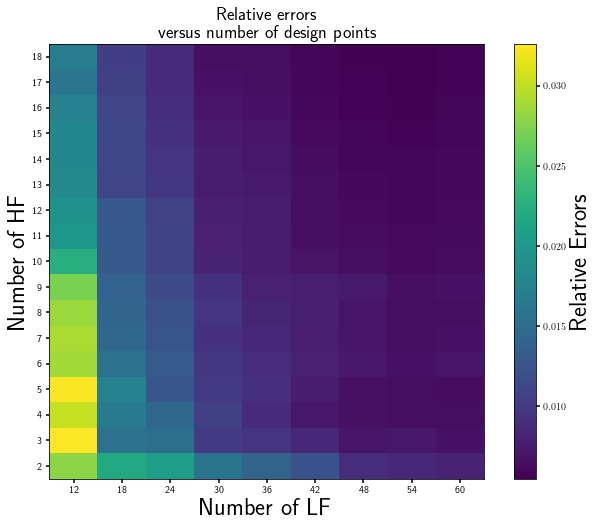

In [14]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

img = ax.imshow(L_H_mean_errors, extent=[0,1,0,1], origin="lower", cmap="viridis")

x_label_list = [str(n_lf) for n_lf in LF_points]
y_label_list = [str(n_hf) for n_hf in HF_points]

ax.set_xticks([(x + 0.5) / len(x_label_list) for x in range(len(x_label_list))])
ax.set_yticks([(y + 0.5) / len(y_label_list) for y in range(len(y_label_list))])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_title("Relative errors\nversus number of design points")

ax.set_xlabel("Number of LF")
ax.set_ylabel("Number of HF")

fig.colorbar(img, label="Relative Errors")

fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_imshow_errors.pdf", bbox_inches='tight', pad_inches=0.075)

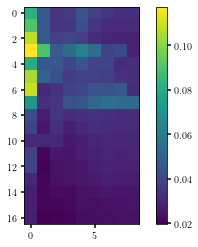

In [16]:
plt.imshow(L_H_max_errors)
plt.colorbar()

## Test on the accuracy limit of LF-only emulator

In [12]:
vloaders.ar1_H3_slice19_added_360.num_lf

[12, 18, 24, 30, 36, 42, 48, 54, 60, 70, 80, 90, 100, 150, 200, 250, 300, 360]

In [11]:
vloaders.ar1_H3_slice19_added_360._pred_exacts_lf.shape

(18, 10, 96)

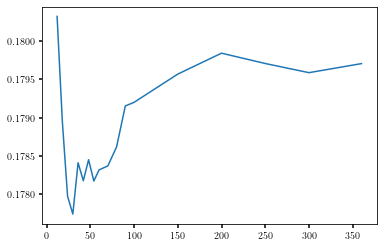

In [20]:
plt.plot(
    vloaders.ar1_H3_slice19_added_360.num_lf,
    np.abs(vloaders.ar1_H3_slice19_added_360._pred_exacts_lf - 1).mean(axis=(1, 2))
)

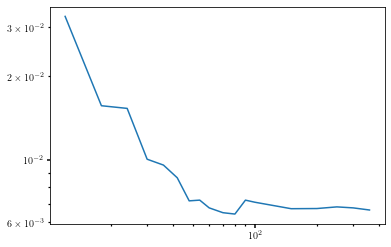

In [22]:
plt.loglog(
    vloaders.ar1_H3_slice19_added_360.num_lf,
    np.abs(vloaders.ar1_H3_slice19_added_360._pred_exacts - 1).mean(axis=(1, 2))
)

Train on 0 ~ 300, test on 60

In [23]:
from matter_multi_fidelity_emu.data_loader import PowerSpecs

In [30]:
import GPy

In [26]:
data = PowerSpecs()
data.read_from_txt("data/processed/Matterpower_360_res128box256_3_res512box256_z0_ind-57-58-59/")

In [37]:
x_test = data.X_train[0][:60]
x_train = data.X_train[0][60:]

y_test = data.Y_train[0][:60]
y_train = data.Y_train[0][60:]

In [47]:
# A loop to train and test
test_points = [6 * i for i in range(2, 51)]

errors = []

for n_lf in test_points:
    x = x_train[:n_lf]
    y = y_train[:n_lf]
    
    # Build your GP here
    nparams = np.shape(x)[1]

    kernel = GPy.kern.RBF(nparams, ARD=True)            

    gp = GPy.models.GPRegression(x, y, kernel)
    
    gp.optimize_restarts(10)
    
    # pred test set
    mean, variance = gp.predict(x_test)
    error = mean / y_test

    errors.append(error)
    
errors = np.array(errors)
errors.shape

Optimization restart 1/10, f = -453.4487985869986
Optimization restart 2/10, f = -453.4487985872622
Optimization restart 3/10, f = -453.4487985872985
Optimization restart 4/10, f = -453.4487985871833
Optimization restart 5/10, f = -453.44879853991733
Optimization restart 6/10, f = -453.44879858222976
Optimization restart 7/10, f = -453.4487985861873
Optimization restart 8/10, f = -453.4487976636251
Optimization restart 9/10, f = -453.4487985650177
Optimization restart 10/10, f = -453.4487985837495
Optimization restart 1/10, f = -1036.2039673925365
Optimization restart 2/10, f = -1036.2039673245447
Optimization restart 3/10, f = -1036.2039673950944
Optimization restart 4/10, f = -1036.2039673945465
Optimization restart 5/10, f = -1037.5436684011793
Optimization restart 6/10, f = -1036.2039672438937
Optimization restart 7/10, f = -1036.2039673800728
Optimization restart 8/10, f = -1036.203967395997
Optimization restart 9/10, f = -1036.203967377713
Optimization restart 10/10, f = -1036.20

Optimization restart 5/10, f = -12640.527180468955
Optimization restart 6/10, f = -12640.527182900667
Optimization restart 7/10, f = -12640.5271605711
Optimization restart 8/10, f = -12640.527182976957
Optimization restart 9/10, f = -12640.527179998866
Optimization restart 10/10, f = -12640.527165190555
Optimization restart 1/10, f = -13402.684008842803
Optimization restart 2/10, f = -13402.68401027232
Optimization restart 3/10, f = -13402.68400784503
Optimization restart 4/10, f = -13402.684011036961
Optimization restart 5/10, f = -13402.68401091381
Optimization restart 6/10, f = -13402.68400366453
Optimization restart 7/10, f = -13402.683980589376
Optimization restart 8/10, f = -13402.684011355484
Optimization restart 9/10, f = -13402.684011411184
Optimization restart 10/10, f = -13402.684011743253
Optimization restart 1/10, f = -14197.707636354799
Optimization restart 2/10, f = -14197.70760155196
Optimization restart 3/10, f = -14197.707636367053
Optimization restart 4/10, f = -1419

Optimization restart 8/10, f = -24810.894350587245
Optimization restart 9/10, f = -24810.89432413805
Optimization restart 10/10, f = -24810.89433126917
Optimization restart 1/10, f = -25696.804009242936
Optimization restart 2/10, f = -25696.80379680286
Optimization restart 3/10, f = -25696.804010663593
Optimization restart 4/10, f = -25696.803990695167
Optimization restart 5/10, f = -25696.804000024706
Optimization restart 6/10, f = -25696.80400600749
Optimization restart 7/10, f = -25696.80400835369
Optimization restart 8/10, f = -25696.804010459797
Optimization restart 9/10, f = -25696.80396565972
Optimization restart 10/10, f = -25696.804004486345
Optimization restart 1/10, f = -26498.118963607154
Optimization restart 2/10, f = -26498.118990099065
Optimization restart 3/10, f = -26498.11898929582
Optimization restart 4/10, f = -26498.118990595736
Optimization restart 5/10, f = -26498.118978970833
Optimization restart 6/10, f = -26498.118988170325
Optimization restart 7/10, f = -2649

(49, 60, 96)

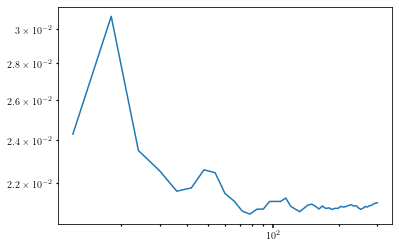

In [58]:
mean = np.abs(errors - 1).mean(axis=(1, 2))
std  = np.abs(errors - 1).std(axis=(1, 2))

plt.loglog(test_points, mean)
# plt.fill_between(test_points, y1=mean - std, y2=mean + std, alpha=0.2)

# plt.fill_between(test_points, y1=mean - std, y2=mean + std, alpha=0.2)